In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style()
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
vars_procedimientos = {f"PROCEDIMIENTO{i}": str for i in range(1, 31)}

In [4]:
df_procesada = pd.read_csv("../data/processed/df_procesada.csv", sep=";", dtype=vars_procedimientos)

C:\Users\ppizarro\AppData\Local\Temp\ipykernel_7140\2020992259.py:1: DtypeWarning: Columns (24,25,26,27,28,29,30,31,32,33,37,41,43,47,51,75,76,77,78,79,80,81,82,83,84,85,86,87,123) have mixed types. Specify dtype option on import or set low_memory=False.
  df_procesada = pd.read_csv("../data/processed/df_procesada.csv", sep=";", dtype=vars_procedimientos)


In [201]:
COLUMNAS_SERVICIO_TRASLADO = {
    "SERVICIOINGRESO": 0,
    "SERVICIOTRASLADO1": 1,
    "SERVICIOTRASLADO2": 2,
    "SERVICIOTRASLADO3": 3,
    "SERVICIOTRASLADO4": 4,
    "SERVICIOTRASLADO5": 5,
    "SERVICIOTRASLADO6": 6,
    "SERVICIOTRASLADO7": 7,
    "SERVICIOTRASLADO8": 8,
    "SERVICIOTRASLADO9": 9,
    "SERVICIOALTA": 10,
}

COLUMNAS_FECHA_TRASLADO = {
    "FECHA_INGRESO": 0,
    "FECHATRASLADO1": 1,
    "FECHATRASLADO2": 2,
    "FECHATRASLADO3": 3,
    "FECHATRASLADO4": 4,
    "FECHATRASLADO5": 5,
    "FECHATRASLADO6": 6,
    "FECHATRASLADO7": 7,
    "FECHATRASLADO8": 8,
    "FECHATRASLADO9": 9,
    "FECHAALTA": 10,
}


# Filtra la base nacional para dejar el Torax
df_torax = df_procesada.query("COD_HOSPITAL == 112103")
# Permite identificar cada egreso
df_torax = df_torax.reset_index().reset_index(names="id_egreso")

In [250]:
# Convierte los servicios y las fechas en formato largo
servicios_egreso_long = df_torax.melt(
    id_vars="id_egreso",
    value_vars=COLUMNAS_SERVICIO_TRASLADO,
    var_name="tipo_servicio",
    value_name="servicio",
)

fechas_egreso_long = df_torax.melt(
    id_vars="id_egreso",
    value_vars=COLUMNAS_FECHA_TRASLADO,
    var_name="tipo_fecha",
    value_name="fecha",
)

In [257]:
# Une los servicios y fechas respectivas para que esten en formato contiguo
recorrido_egreso = pd.merge(
    left=fechas_egreso_long,
    right=servicios_egreso_long,
    how="inner",
    left_index=True,
    right_index=True,
)

# Indica el tipo de ordenamiento del tipo de servicio ("SERVICIONGR", "SERVICIO1", "SERVICIOALTA")
recorrido_egreso["tipo_servicio"] = pd.Categorical(
    recorrido_egreso["tipo_servicio"],
    categories=COLUMNAS_SERVICIO_TRASLADO.keys(),
    ordered=True,
)

# Ordena cada egreso segun su tipo de servicio ("SERVICIONGR", "SERVICIO1", "SERVICIOALTA")
recorrido_egreso = recorrido_egreso.sort_values(["id_egreso_x", "tipo_servicio"])

# Elimina filas sin ninguna fecha ingresada
recorrido_egreso = recorrido_egreso.dropna()

# Resetea los indices para que sean contiguos
recorrido_egreso = recorrido_egreso.reset_index(drop=True)

# Imputa fechas con formato de fechas
recorrido_egreso["fecha"] = pd.to_datetime(recorrido_egreso["fecha"])

In [258]:
# Calcula el tiempo de estancia por servicio
recorrido_egreso["tiempo_de_estancia"] = (
    recorrido_egreso.groupby("id_egreso_x")["fecha"].diff().shift(-1)
)

# Identifica las fechas mal imputadas, donde el tiempo de estancia es negativo
indices_egresos_con_tiempos_negativos = (
    recorrido_egreso[recorrido_egreso["tiempo_de_estancia"] < np.timedelta64(0)].index + 1
)

# Modifica las fechas erroneas, agregando 1 anio a la fecha
recorrido_egreso.loc[indices_egresos_con_tiempos_negativos, "fecha"] = recorrido_egreso.loc[
    indices_egresos_con_tiempos_negativos, "fecha"
] + pd.offsets.DateOffset(years=1)

# Recalcula el tiempo de estancia por servicio
recorrido_egreso["tiempo_de_estancia"] = (
    recorrido_egreso.groupby("id_egreso_x")["fecha"].diff().shift(-1)
)

# Identifica las fechas mal imputadas, donde el tiempo de estancia es negativo
indices_egresos_con_tiempos_0 = (
    recorrido_egreso[recorrido_egreso["tiempo_de_estancia"] == np.timedelta64(0)].index
)

# Modifica las fechas donde el tiempo es 0, imputandolos como 1 dia
recorrido_egreso.loc[indices_egresos_con_tiempos_0, "tiempo_de_estancia"] = recorrido_egreso.loc[
    indices_egresos_con_tiempos_0, "tiempo_de_estancia"
] + pd.Timedelta(days=1)

<Axes: ylabel='servicio'>

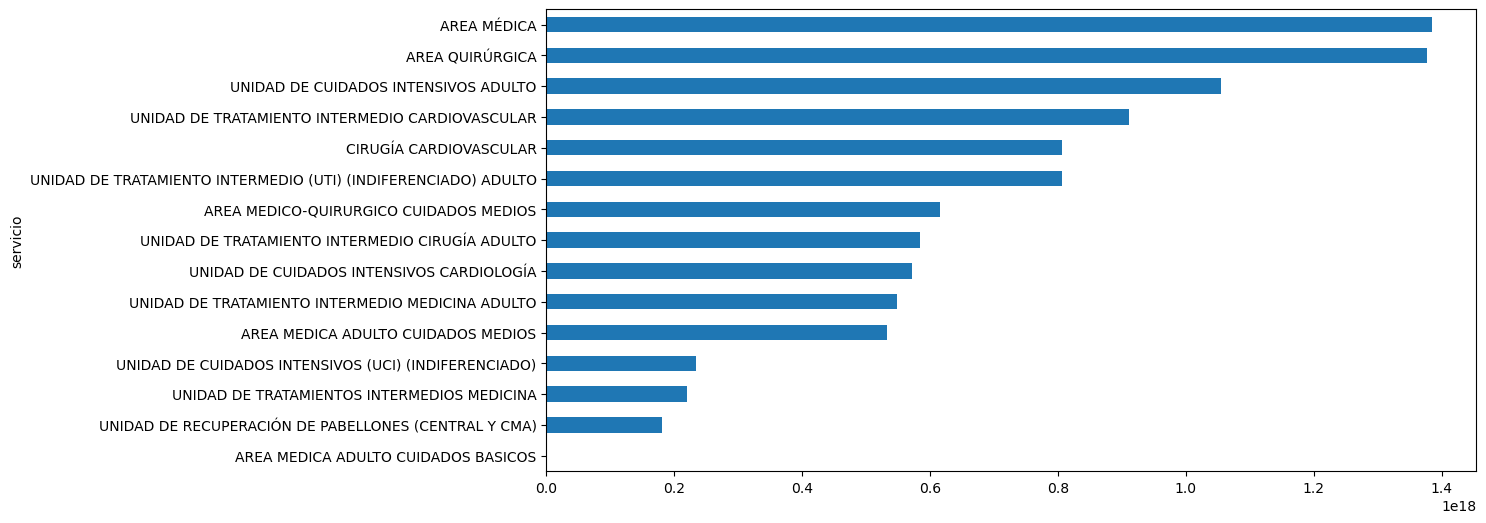

In [265]:
recorrido_egreso.groupby("servicio")["tiempo_de_estancia"].sum().sort_values().plot(kind="barh")